In [2]:
from IPython.display import display,Image,clear_output
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns
import random
import urllib.request
import h5py

from collections import Counter,defaultdict

In [2]:
import keras 
from keras.utils.data_utils import get_file  #?
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3  #?
from keras.applications.imagenet_utils import preprocess_input, decode_predictions  #?
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras.models import save_model

Using TensorFlow backend.
/home/akash/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from keras import backend as K
K.backend()

'tensorflow'

### Using tensorflow as backend

In [4]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [5]:
# from Keras GitHub  
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

### Creating instances of model

In [6]:
vgg16 = VGG16(weights='imagenet')     # weights -> None,'imagenet' **None** implies random initialization while 'imagenet' species loading
                                      # weights pretrained on imagenet
resnet50 = ResNet50(weights='imagenet')
vgg19 = VGG19(weights='imagenet')
inception = InceptionV3(weights='imagenet')

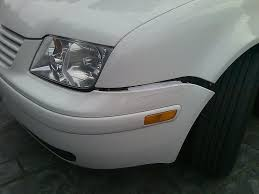

In [28]:
dataset = './car-damage-dataset/data1a/training/00-damage'
images = os.listdir(dataset)
img = random.choice(images)
dest_path = os.path.join(dataset,img)
Image(dest_path,width=200)

In [29]:
def prepare_image(img_path):
    img = load_img(path=img_path,target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)         #?
    return x

In [30]:
y = prepare_image(dest_path)
preds = vgg16.predict(y)
print(get_predictions(preds,top=5))

[[('n03670208', 'limousine', 0.52372289), ('n03100240', 'convertible', 0.083323032), ('n03770679', 'minivan', 0.079809822), ('n02974003', 'car_wheel', 0.058206193), ('n03459775', 'grille', 0.055540577)]]


In [31]:
preds = resnet50.predict(y)
print(get_predictions(preds,top=5))

[[('n03670208', 'limousine', 0.47989562), ('n02974003', 'car_wheel', 0.1547776), ('n02930766', 'cab', 0.065002821), ('n03100240', 'convertible', 0.051943328), ('n04285008', 'sports_car', 0.046451349)]]


In [26]:
preds = vgg19.predict(y)
print(get_predictions(preds,top=5))

[[('n03459775', 'grille', 0.30603939), ('n03127747', 'crash_helmet', 0.26111087), ('n04285008', 'sports_car', 0.13092306), ('n03770679', 'minivan', 0.11826289), ('n03100240', 'convertible', 0.028974909)]]


### Using VGG16 as gate (also check ResNet50)

In [82]:
vgg16.save('vgg16.h5')

In [42]:
img_list = os.listdir('./car-damage-dataset/data1a/training/')
# sab uttana h ki training
img_list

['01-whole', '00-damage']

In [44]:
img_pathshs = []
for x in img_list:
    img_paths += os.listdir('./car-damage-dataset/data1a/training/' + x)
img_paths[:len(os.listdir('./car-damage-dataset/data1a/training/01-whole/'))] = ['./car-damage-dataset/data1a/training/01-whole/' + x for x in img_paths[:len(os.listdir('./car-damage-dataset/data1a/training/01-whole/'))]]
img_paths[len(os.listdir('./car-damage-dataset/data1a/training/00-damage//')):] = ['./car-damage-dataset/data1a/training/00-damage/' + x for x in img_paths[len(os.listdir('./car-damage-dataset/data1a/training/00-damage//')):]]
img_paths

['./car-damage-dataset/data1a/training/01-whole/0508.jpg',
 './car-damage-dataset/data1a/training/01-whole/0292.jpg',
 './car-damage-dataset/data1a/training/01-whole/0427.jpg',
 './car-damage-dataset/data1a/training/01-whole/0173.jpg',
 './car-damage-dataset/data1a/training/01-whole/0448.jpg',
 './car-damage-dataset/data1a/training/01-whole/0433.jpg',
 './car-damage-dataset/data1a/training/01-whole/0305.jpg',
 './car-damage-dataset/data1a/training/01-whole/0318.jpg',
 './car-damage-dataset/data1a/training/01-whole/0275.jpg',
 './car-damage-dataset/data1a/training/01-whole/0395.jpg',
 './car-damage-dataset/data1a/training/01-whole/0688.jpg',
 './car-damage-dataset/data1a/training/01-whole/0196.jpg',
 './car-damage-dataset/data1a/training/01-whole/0036.jpg',
 './car-damage-dataset/data1a/training/01-whole/0116.jpg',
 './car-damage-dataset/data1a/training/01-whole/0043.jpg',
 './car-damage-dataset/data1a/training/01-whole/0235.jpg',
 './car-damage-dataset/data1a/training/01-whole/0799.JPE

In [48]:
def get_car_categories():
    d = defaultdict(float)
    # img_list = os.listdir('./car-damage-dataset/data1a/training/')    # cross-check the path
    for i,img_path in enumerate(img_paths):
        img = prepare_image(img_path)
        out = vgg16.predict(img)
        top = get_predictions(out,top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 50 == 0:
            print(i, '/', len(img_paths), 'complete')
    return Counter(d)

In [49]:
cat_counter = get_car_categories()

0 / 1840 complete
50 / 1840 complete
100 / 1840 complete
150 / 1840 complete
200 / 1840 complete
250 / 1840 complete
300 / 1840 complete
350 / 1840 complete
400 / 1840 complete
450 / 1840 complete
500 / 1840 complete
550 / 1840 complete
600 / 1840 complete
650 / 1840 complete
700 / 1840 complete
750 / 1840 complete
800 / 1840 complete
850 / 1840 complete
900 / 1840 complete
950 / 1840 complete
1000 / 1840 complete
1050 / 1840 complete
1100 / 1840 complete
1150 / 1840 complete
1200 / 1840 complete
1250 / 1840 complete
1300 / 1840 complete
1350 / 1840 complete
1400 / 1840 complete
1450 / 1840 complete
1500 / 1840 complete
1550 / 1840 complete
1600 / 1840 complete
1650 / 1840 complete
1700 / 1840 complete
1750 / 1840 complete
1800 / 1840 complete


In [53]:
cat_counter

Counter({('n01484850', 'great_white_shark'): 0.083000890910625458,
         ('n01498041', 'stingray'): 0.043295502662658691,
         ('n01742172', 'boa_constrictor'): 0.04263218492269516,
         ('n01744401', 'rock_python'): 0.041214603930711746,
         ('n01770393', 'scorpion'): 0.2146964818239212,
         ('n01774384', 'black_widow'): 0.2633679211139679,
         ('n01774750', 'tarantula'): 0.081851810216903687,
         ('n01833805', 'hummingbird'): 0.18340960144996643,
         ('n01910747', 'jellyfish'): 0.057170446962118149,
         ('n02066245', 'grey_whale'): 0.061279192566871643,
         ('n02071294', 'killer_whale'): 0.098059669137001038,
         ('n02110341', 'dalmatian'): 0.040717586874961853,
         ('n02233338', 'cockroach'): 0.041311688721179962,
         ('n02280649', 'cabbage_butterfly'): 0.0033585999626666307,
         ('n02410509', 'bison'): 0.1151474229991436,
         ('n02415577', 'bighorn'): 0.043276069685816765,
         ('n02437616', 'llama'): 0.0576

In [61]:
cat_list = [k for k, v in cat_counter.most_common()[:48]]

In [62]:
cat_counter.most_common()[:48]

[(('n03770679', 'minivan'), 234.5391904686112),
 (('n04285008', 'sports_car'), 178.86453327257186),
 (('n03100240', 'convertible'), 105.31959413830191),
 (('n02814533', 'beach_wagon'), 90.158238039410207),
 (('n03930630', 'pickup'), 83.770066296448931),
 (('n04461696', 'tow_truck'), 58.249366191215813),
 (('n03670208', 'limousine'), 57.05276084470097),
 (('n04037443', 'racer'), 55.184417598007713),
 (('n02974003', 'car_wheel'), 45.143197273137048),
 (('n02930766', 'cab'), 44.370929819764569),
 (('n03769881', 'minibus'), 37.775627345778048),
 (('n03796401', 'moving_van'), 34.106739734997973),
 (('n03594945', 'jeep'), 29.740893859183416),
 (('n03459775', 'grille'), 29.282155497356143),
 (('n03445924', 'golfcart'), 22.476905229501426),
 (('n03791053', 'motor_scooter'), 21.971912591718137),
 (('n04252225', 'snowplow'), 19.098501105327159),
 (('n03977966', 'police_van'), 18.822342023486272),
 (('n02965783', 'car_mirror'), 14.878371320664883),
 (('n03417042', 'garbage_truck'), 11.72774335602

In [63]:
cat_list

[('n03770679', 'minivan'),
 ('n04285008', 'sports_car'),
 ('n03100240', 'convertible'),
 ('n02814533', 'beach_wagon'),
 ('n03930630', 'pickup'),
 ('n04461696', 'tow_truck'),
 ('n03670208', 'limousine'),
 ('n04037443', 'racer'),
 ('n02974003', 'car_wheel'),
 ('n02930766', 'cab'),
 ('n03769881', 'minibus'),
 ('n03796401', 'moving_van'),
 ('n03594945', 'jeep'),
 ('n03459775', 'grille'),
 ('n03445924', 'golfcart'),
 ('n03791053', 'motor_scooter'),
 ('n04252225', 'snowplow'),
 ('n03977966', 'police_van'),
 ('n02965783', 'car_mirror'),
 ('n03417042', 'garbage_truck'),
 ('n02701002', 'ambulance'),
 ('n04252077', 'snowmobile'),
 ('n04467665', 'trailer_truck'),
 ('n03478589', 'half_track'),
 ('n03891332', 'parking_meter'),
 ('n03777568', 'Model_T'),
 ('n04065272', 'recreational_vehicle'),
 ('n03127747', 'crash_helmet'),
 ('n03649909', 'lawn_mower'),
 ('n02704792', 'amphibian'),
 ('n04517823', 'vacuum'),
 ('n02917067', 'bullet_train'),
 ('n04465501', 'tractor'),
 ('n03785016', 'moped'),
 ('n0377

### Load Pickle Point

In [64]:
with open('cat_counter.pk','wb') as f:
    pickle.dump(cat_counter,f,-1)

In [3]:
with open('cat_counter.pk','rb') as f:
    cat_counter = pickle.load(f)

In [4]:
cat_list = [k for k,v in cat_counter.most_common()[:48]]

In [5]:
cat_list

[('n03770679', 'minivan'),
 ('n04285008', 'sports_car'),
 ('n03100240', 'convertible'),
 ('n02814533', 'beach_wagon'),
 ('n03930630', 'pickup'),
 ('n04461696', 'tow_truck'),
 ('n03670208', 'limousine'),
 ('n04037443', 'racer'),
 ('n02974003', 'car_wheel'),
 ('n02930766', 'cab'),
 ('n03769881', 'minibus'),
 ('n03796401', 'moving_van'),
 ('n03594945', 'jeep'),
 ('n03459775', 'grille'),
 ('n03445924', 'golfcart'),
 ('n03791053', 'motor_scooter'),
 ('n04252225', 'snowplow'),
 ('n03977966', 'police_van'),
 ('n02965783', 'car_mirror'),
 ('n03417042', 'garbage_truck'),
 ('n02701002', 'ambulance'),
 ('n04252077', 'snowmobile'),
 ('n04467665', 'trailer_truck'),
 ('n03478589', 'half_track'),
 ('n03891332', 'parking_meter'),
 ('n03777568', 'Model_T'),
 ('n04065272', 'recreational_vehicle'),
 ('n03127747', 'crash_helmet'),
 ('n03649909', 'lawn_mower'),
 ('n02704792', 'amphibian'),
 ('n04517823', 'vacuum'),
 ('n02917067', 'bullet_train'),
 ('n04465501', 'tractor'),
 ('n03785016', 'moped'),
 ('n0377

In [6]:
with open('vgg16_cat_list.pk','wb') as f:
    pickle.dump(cat_list,f,-1)

### Evaluating Car Categories from Imagenet

In [69]:
def get_car_categories_with_cat_list(cat_list):
    num = 0
    bad_list = []
    for i,img_path in enumerate(img_paths):
        img = prepare_image(img_path)
        out = vgg16.predict(img)
        top = get_predictions(out,top=5)
        for j in top[0]:
            if j[0:2] in cat_list:
                num += 1
                break # breaks out of for loop if one of top 50 categories is found
            bad_list.append(img_path)  # appends to "bad list" if none of the 50 are found
        if i % 100 == 0:
            print(i, '/', len(img_paths), 'complete')
    bad_list = [k for k, v in Counter(bad_list).iteritems() if v == 5]   #?
    return num, bad_list

In [70]:
number, bad_list = get_car_categories_with_cat_list(cat_list)

0 / 1840 complete
100 / 1840 complete
200 / 1840 complete
300 / 1840 complete
400 / 1840 complete
500 / 1840 complete
600 / 1840 complete
700 / 1840 complete
800 / 1840 complete
900 / 1840 complete
1000 / 1840 complete
1100 / 1840 complete
1200 / 1840 complete
1300 / 1840 complete
1400 / 1840 complete
1500 / 1840 complete
1600 / 1840 complete
1700 / 1840 complete
1800 / 1840 complete


AttributeError: 'Counter' object has no attribute 'iteritems'

## Select top 50 as cutoff for category list

In [55]:
def view_images(img_paths):
    for img in img_paths:
        clear_output()
        display(Image(img,width=200))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

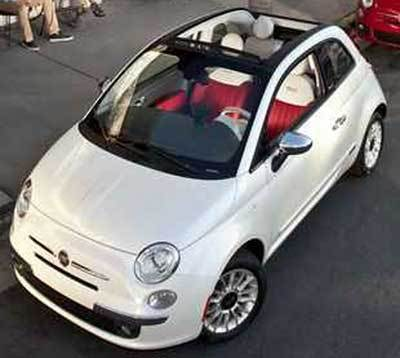

c to continue, q to quit


'Finished for now.'

In [56]:
view_images(img_paths)

In [77]:
def car_categories_gate(img_url,cat_list):
    urllib.request.urlretrieve(img_url,'save.jpg')
    x = prepare_image('save.jpg')
    out = vgg16.predict(x)
    top = get_predictions(out,top=5)
    print("Validating that this is a picture of your car...")
    for j in top[0]:
        if j[0:2] in cat_list:
            print(j[0:2])
            return "Validation complete - proceed to damage evaluation"
    return "Are you sure this is a picture of your car? Please take another picture \
(try a different angle or lighting) and try again."

In [78]:
car_categories_gate('https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcSxhKhaSwPgdQkrDegC6sbUALBF9SiW6tDKg6dLDYj83e19krxy', cat_list)

Validating that this is a picture of your car...
('n02930766', 'cab')


'Validation complete - proceed to damage evaluation'

In [79]:
car_categories_gate('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7xHO3j12Xk4q4eaQUL1A02k1HrJ9G_RY6tj-4h-07EfdML6YL', cat_list)

Validating that this is a picture of your car...
('n03445924', 'golfcart')


'Validation complete - proceed to damage evaluation'